In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
import random
from scipy.integrate import simps

In [408]:
# import data
data_treasury = pd.read_csv('/Users/archibaldgonah/Desktop/Masters work/Code-Work/data/3-month treasury bill.csv')
# convert date strings to datetime objects (assuming proper date format)
data_treasury['DATE'] = pd.to_datetime(data_treasury['DATE'])
data_treasury.set_index('DATE', inplace=True)

data_treasury.dtypes

DTB3    object
dtype: object

In [409]:
# converting column to float
def convert_to_numeric(column):
  try:
    return float(column.replace(',', '')) 
  except ValueError:
    return None 

data_treasury['DTB3'] = data_treasury['DTB3'].apply(convert_to_numeric)

data_treasury.head()


,DTB3
DATE,
2019-06-12,2.19
2019-06-13,2.14
2019-06-14,2.15
2019-06-17,2.18
2019-06-18,2.17


Our data is from 2019-06 to 2024-06

In [410]:
# checking data
data_treasury.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2019-06-12 to 2024-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTB3    1253 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In order to handle null values we are going to use Forward fill. 

This will propagate the last valid rate forward to fill the missing value. 

In [411]:
# handling nun-values

data_treasury['DTB3'] = data_treasury['DTB3'].fillna(method='ffill')

In [412]:
# check data
data_treasury.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2019-06-12 to 2024-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DTB3    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


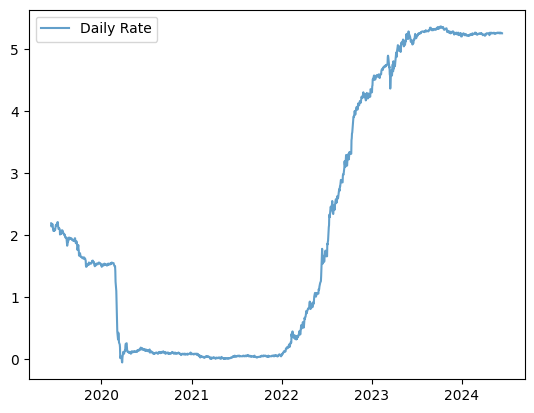

In [413]:
# plot both original
plt.plot(data_treasury['DTB3'], linestyle='-', alpha=0.7, label='Daily Rate')  # Adjust alpha for transparency
plt.legend()

Now lets optimize our parameters for CIR model using our historical data. We are using the CIR model to get the risk-free rate for 2024 (estimated).

In [414]:
random.seed(46)
# define the CIR model likelihood function
def cir_log_likelihood(params, rates, dt):
    kappa, theta, sigma = params
    n = len(rates)
    ll = 0.0
    
    for i in range(1, n):
        r_t = rates[i-1]
        r_t1 = rates[i]
        
    
        mean_r_t1 = r_t * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        var_r_t1 = (sigma**2 * r_t * (1 - np.exp(-2 * kappa * dt))) / (2 * kappa)
        
        
        var_r_t1 = max(var_r_t1, 1e-10)
        
        # log-likelihood of observing r_t1 given r_t
        ll += -0.5 * (np.log(2 * np.pi * var_r_t1) + ((r_t1 - mean_r_t1)**2) / var_r_t1)
    
    
    return -ll

# define the initial parameters and the interest rate time series
initial_params = [0.1, 0.02, 0.1]  
rates = np.array(data_treasury['DTB3'] / 100) 
dt = 1 / 252  

# perform the optimization to find the best-fit parameters
result = minimize(cir_log_likelihood, initial_params, args=(rates, dt), method='L-BFGS-B',
                  bounds=[(1e-5, None), (1e-5, None), (1e-5, None)])


kappa_opt, theta_opt, sigma_opt = result.x

print(f"Optimal parameters: kappa = {kappa_opt}, theta = {theta_opt}, sigma = {sigma_opt}")


Optimal parameters: kappa = 2.3254288355309765, theta = 0.017426814468824353, sigma = 0.09867955137378603


In [415]:
data_treasury.index[len(data_treasury.index) - 1]

Timestamp('2024-06-12 00:00:00')

In [416]:
last_date = data_treasury.index[len(data_treasury.index) - 1]
future_date = datetime(2024,12,31)
difference = future_date - last_date

In [417]:
# CIR model parameters
mean_reversion_rate = kappa_opt 
long_run_average = theta_opt    
volatility = sigma_opt          
initial_rate = data_treasury.iloc[-1][0] / 100    
time_horizon = 1        
num_steps = 144 # trading days from 2024-6-12 to 2024-12-31     


dt = time_horizon / num_steps


interest_rates = np.zeros(num_steps + 1)
interest_rates[0] = initial_rate

for i in range(1, num_steps + 1):
    drift = mean_reversion_rate * (long_run_average - interest_rates[i-1])
    diffusion = volatility * np.sqrt(interest_rates[i-1]) * np.random.normal(scale=np.sqrt(dt))
    interest_rates[i] = interest_rates[i-1] + drift * dt + diffusion


avg_rate = simps(interest_rates, dx=dt) / time_horizon

print("Simulated Interest Rates:")
print(interest_rates * 100)
print("\nAverage Interest Rate:", avg_rate * 100)


Simulated Interest Rates:
[5.25       5.25850877 4.98146579 5.01673863 5.20609591 5.23108467
 4.94114084 5.13232887 5.29562613 5.2210662  4.96087151 4.82278641
 4.80817666 4.9929231  4.86131484 4.82725789 5.23592246 5.36995867
 5.27171445 5.26140515 4.9205314  5.01441488 4.89412021 4.79030325
 4.83021944 4.81580109 4.64499181 4.5460263  4.36011448 4.20074732
 4.37385221 4.59337085 4.66691119 4.68266721 4.79742698 4.91103626
 4.78101457 4.65838052 4.87893352 4.79006743 4.56871041 4.34157386
 4.35806206 4.51854952 4.30000314 4.23732677 4.08996921 4.03878159
 4.06108247 4.08493838 4.3069328  4.45222403 4.49193857 4.26447836
 4.03715229 4.08832131 3.96150813 4.00081477 3.86103148 3.73467586
 3.80903534 3.814566   3.67530385 3.69327734 3.61592522 3.42666402
 3.33093452 3.5924037  3.56812089 3.53910485 3.43035515 3.34893379
 3.25149304 2.81463144 2.9921026  3.02541618 2.94020039 2.66393959
 2.70940635 2.53754061 2.29621303 2.34013761 2.0685359  1.92929975
 1.85008141 1.81336916 1.88545193 1.

In [418]:
np.append(np.array(data_treasury['DTB3'].loc['2024-1-1':]), np.array(interest_rates)).mean()

2.3693276948807807